# vitalAperiodic

The vitalAperiodic table provides invasive vital sign data which is interfaced into eCareManager at irregular intervals. Unlike most tables in eICU-CRD, vitalAperiodic does not use an entity-attribute-value model, but rather has an individual column to capture each data element. Columns available include:

* Blood pressures: nonInvasiveSystolic, nonInvasiveDiastolic, nonInvasiveMean
* Cardiac output measures: cardiacOutput, cardiacInput
* Systemic circulation measures: svr, svri, pvr, pvri
* Pulmonary pressures: pulmonary artery occlusion pressure (paop)

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import psycopg2
import getpass

# for configuring connection 
from configobj import ConfigObj
import os

%matplotlib inline

/home/alistairewj/.local/lib/python3.5/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [2]:
# Create a database connection using settings from config file
config='../db/config.ini'

# connection info
conn_info = dict()
if os.path.isfile(config):
    config = ConfigObj(config)
    conn_info["sqluser"] = config['username']
    conn_info["sqlpass"] = config['password']
    conn_info["sqlhost"] = config['host']
    conn_info["sqlport"] = config['port']
    conn_info["dbname"] = config['dbname']
    conn_info["schema_name"] = config['schema_name']
else:
    conn_info["sqluser"] = 'postgres'
    conn_info["sqlpass"] = ''
    conn_info["sqlhost"] = 'localhost'
    conn_info["sqlport"] = 5432
    conn_info["dbname"] = 'eicu'
    conn_info["schema_name"] = 'public,eicu_crd'
    
# Connect to the eICU database
print('Database: {}'.format(conn_info['dbname']))
print('Username: {}'.format(conn_info["sqluser"]))
if conn_info["sqlpass"] == '':
    # try connecting without password, i.e. peer or OS authentication
    try:
        if (conn_info["sqlhost"] == 'localhost') & (conn_info["sqlport"]=='5432'):
            con = psycopg2.connect(dbname=conn_info["dbname"],
                                   user=conn_info["sqluser"])            
        else:
            con = psycopg2.connect(dbname=conn_info["dbname"],
                                   host=conn_info["sqlhost"],
                                   port=conn_info["sqlport"],
                                   user=conn_info["sqluser"])
    except:
        conn_info["sqlpass"] = getpass.getpass('Password: ')

        con = psycopg2.connect(dbname=conn_info["dbname"],
                               host=conn_info["sqlhost"],
                               port=conn_info["sqlport"],
                               user=conn_info["sqluser"],
                               password=conn_info["sqlpass"])
query_schema = 'set search_path to ' + conn_info['schema_name'] + ';'

Database: eicu
Username: alistairewj


## Examine a single patient

In [8]:
patientunitstayid = 145467

In [17]:
query = query_schema + """
select *
from vitalaperiodic
where patientunitstayid = {}
order by observationoffset
""".format(patientunitstayid)

df = pd.read_sql_query(query, con)
df.head()

,patientunitstayid,vitalaperiodicid,observationyear,observationtime24,observationtime,observationoffset,noninvasivesystolic,noninvasivediastolic,noninvasivemean,paop,cardiacoutput,cardiacinput,svr,svri,pvr,pvri
0,145467,4223721,2014,19:33:34,night,4,113.0,62.0,81.0,None,NaN,NaN,NaN,NaN,NaN,NaN
1,145467,4223722,2014,20:13:06,night,44,NaN,NaN,NaN,None,3.9,1.9,1496.0,3099.0,123.0,255.0
2,145467,4223723,2014,20:59:54,night,90,NaN,NaN,NaN,None,4.3,2.1,1357.0,2810.0,112.0,231.0
3,145467,4223724,2014,00:04:04,midnight,275,NaN,NaN,NaN,None,4.5,2.2,1012.0,2097.0,107.0,221.0
4,145467,4223725,2014,06:40:46,midday,671,NaN,NaN,NaN,None,7.8,3.8,NaN,NaN,72.0,149.0


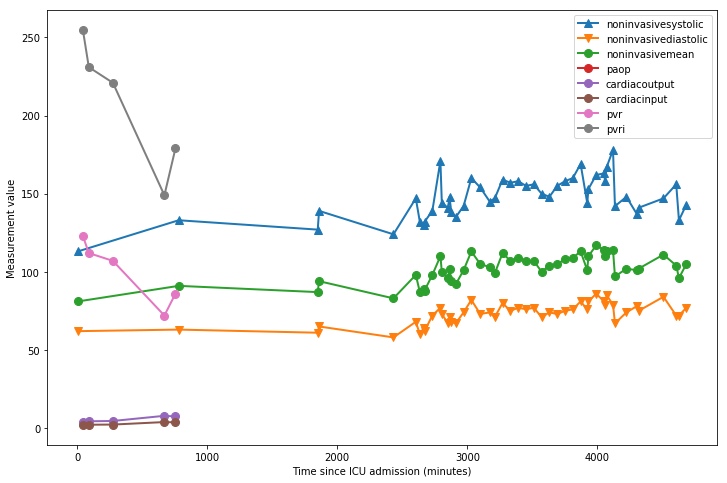

In [18]:
# list of columns to plot
vitals = ['noninvasivesystolic', 'noninvasivediastolic', 'noninvasivemean',
          'paop',
          'cardiacoutput', 'cardiacinput',
          'pvr', 'pvri']
# we exclude  'svr', 'svri' from the plot as their scale is too high

plt.figure(figsize=[12,8])
for v in vitals:
    df_plot = df[['observationoffset', v]].dropna()
    if 'systolic' in v:
        marker = '^-'
    elif 'diastolic' in v:
        marker = 'v-'
    else:
        marker = 'o-'
        
    plt.plot(df_plot['observationoffset'],
             pd.to_numeric(df_plot[v], errors='coerce'),
            marker, markersize=8, lw=2, label=v)
    
plt.xlabel('Time since ICU admission (minutes)')
plt.ylabel('Measurement value')
plt.legend(loc='upper right')
plt.show()

## Hospitals with data available

In [14]:
query = query_schema + """
with t as
(
select distinct patientunitstayid
from vitalaperiodic
)
select 
  pt.hospitalid
  , count(distinct pt.patientunitstayid) as number_of_patients
  , count(distinct t.patientunitstayid) as number_of_patients_with_tbl
from patient pt
left join t
  on pt.patientunitstayid = t.patientunitstayid
group by pt.hospitalid
""".format(patientunitstayid)

df = pd.read_sql_query(query, con)
df['data completion'] = df['number_of_patients_with_tbl'] / df['number_of_patients'] * 100.0
df.sort_values('number_of_patients_with_tbl', ascending=False, inplace=True)
df.head(n=10)

,hospitalid,number_of_patients,number_of_patients_with_tbl,data completion
11,73,7059,6635,93.993483
54,167,6092,5585,91.677610
106,264,5237,5018,95.818217
184,420,4679,4432,94.721094
134,338,4277,4181,97.755436
90,243,4243,4105,96.747584
58,176,4328,3931,90.827172
71,199,4240,3890,91.745283
206,458,3701,3642,98.405836
80,208,3650,3581,98.109589


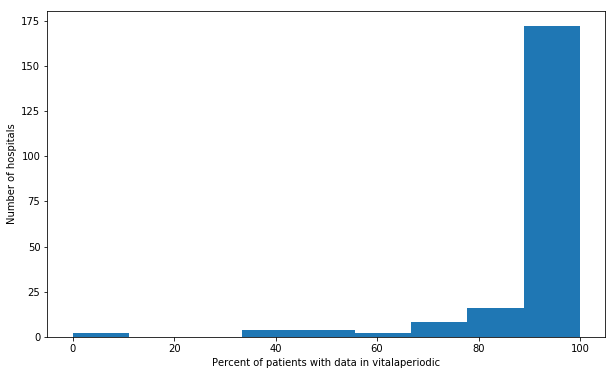

In [15]:
plt.figure(figsize=[10,6])
plt.hist(df['data completion'], bins=np.linspace(0, 100, 10))
plt.xlabel('Percent of patients with data in vitalaperiodic')
plt.ylabel('Number of hospitals')
plt.show()

Most hospitals in eICU have good data coverage for the vitalaperiodic table.